In [1]:
import numpy as np
import pandas as pd
from datetime import datetime

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

In [75]:
import sys
sys.path.append('../')

from axia.data_handler import DataHandler
from axia.shifted_beta_geometric import ShiftedBetaGeometric
from axia.sbg_survival import SBGSurvival
from axia import util
from axia import report

from importlib import reload

# Data: Load, Preprocess, and Split

In [6]:
def _top_5_countries(c):
    if c in ['United States', 'Canada', 'United Kingdom', 'Australia', 'New Zealand']:
        return c.lower().replace(" ", "_")
    return "other_country"


def _top_20_crm_industries(c):
    if c in ['Lawn Care & Lawn Maintenance', 'Other', 'Residential Cleaning',
       'Construction & Contracting', 'HVAC', 'Landscaping Contractor',
       'Plumbing', 'Electrical Contractor', 'Commercial Cleaning',
       'Arborist / Tree Care', 'Pest Control', 'Window Washing', 'Handyman',
       'Pressure Washing Service', 'Pool and Spa Service', 'Renovations',
       'Painting', 'Computers & IT', 'Carpet Cleaning', 'Mechanical Service']:
        return c.lower().replace(" ", "_")
    return "other_industry"


def _end_date(dt):
    if pd.isnull(dt):
        return dt
    return dt.strftime("%Y-%m-01")

In [25]:
ltv = pd.read_csv("../data/ltv_per_customer-2019-02-15-19-52-31.csv", index_col=["account_id"])
# df = pd.read_csv("../data/master_dataset-2019-02-19-14-29-24.csv", parse_dates=["first_paying_date", "last_churn_date"])
df = pd.read_csv("../data/JOBBER_master_dataset_with_billing_freq-_2019-02-28.csv", parse_dates=["first_paying_date", "last_churn_date"])

df = df.drop_duplicates()
df.set_index("account_id", inplace=True)
df = df.dropna(how="all", subset=["initial_subscription_amt", "current_subscription_amt"])

irrelevant_cols = [
    'attr_channel_category_v1',
    'attr_channel_v1', 'heard_about_us', 'heard_about_us_category',
    'heard_about_us_sub_category', 'hdyhau_channel',
    'hdyhau_channel_category', 'utmz_channel_category', 'utmz_channel',
    'lifecycle_state', 'account_created_month', 'first_paying_month',
]
df.drop(irrelevant_cols, axis=1, inplace=True)

df = df.join(ltv.drop("lifecycle_state", axis=1))
df = df.fillna({'paying_months': 0, 'tot_revenue': 0})
df.rename(
    columns={
        "crm_industry": "industry",
        "initial_billing_frequency": "frequency",
    },
    inplace=True
)

df = df[df['frequency'] != "Unknown"]

# df = df.sample(n=100, random_state=7)

In [26]:
df.head()

,country,industry,account_created_date,first_paying_date,last_churn_date,days_to_paying,initial_subscription_amt,current_subscription_amt,frequency,current_billing_frequency,is_paying,paying_months,tot_revenue
account_id,,,,,,,,,,,,,
2,Canada,Painting,2010-10-27 00:00:00,2011-04-06,NaT,161,65.0,128.0,monthly,monthly,1,62.0,5326.0
34,Canada,Arborist / Tree Care,2011-02-04 00:00:00,2012-04-12,NaT,433,47.0,47.0,monthly,monthly,1,62.0,3222.0
87,United States,Lawn Care & Lawn Maintenance,2011-04-10 00:00:00,2014-04-16,2015-02-02,1102,39.0,39.0,monthly,monthly,1,58.0,2223.0
109,Canada,Painting,2011-04-26 00:00:00,2011-05-31,NaT,35,38.0,47.0,monthly,monthly,1,62.0,2608.0
137,United States,Mechanical Service,2011-06-13 00:00:00,2016-03-03,2016-08-03,1725,68.0,68.0,monthly,monthly,0,5.0,340.0


In [27]:
%%time
reload(util)
data = util.SubscriptionData(
    data=df,
    start_date_col="first_paying_date",
    end_date_col="last_churn_date",
    subscription_initial="initial_subscription_amt",
    subscription_current="current_subscription_amt",
    additional_cols=[
        df["country"].apply(_top_5_countries).astype("category"),
        df["industry"].apply(_top_20_crm_industries).astype("category"),
        df["frequency"].astype("category"),
    ]
)

CPU times: user 3min 55s, sys: 1.14 s, total: 3min 57s
Wall time: 3min 57s


In [28]:
data.df.head()

,start_date,end_date,age,alive,subscription_initial,subscription_last,subscription_current,country,industry,frequency
account_id,,,,,,,,,,
2,2011-04-01,NaT,95,1,65.0,128.0,128.0,canada,painting,monthly
34,2012-04-01,NaT,83,1,47.0,47.0,47.0,canada,arborist_/_tree_care,monthly
87,2014-04-01,2015-02-01,10,0,39.0,39.0,0.0,united_states,lawn_care_&_lawn_maintenance,monthly
109,2011-05-01,NaT,94,1,38.0,47.0,47.0,canada,painting,monthly
137,2016-03-01,2016-08-01,5,0,68.0,68.0,0.0,united_states,mechanical_service,monthly


# Actuals

In [76]:
rep = report.ReportActuals(subscription_data=data)

In [78]:
rep.observed_ltv()

,alive,subscription_value_base,value_to_date_base,subscription_value_linear,value_to_date_linear
mean,0.71545,53.874027,747.367149,55.928243,760.074008
10%,0.00000,0.000000,177.000000,0.000000,181.000000
50%,1.00000,49.000000,684.000000,53.000000,684.000000
90%,1.00000,114.000000,1392.000000,121.217391,1404.214286


In [79]:
rep.observed_ltv(cutoff_date="2015-01-01")

,alive,subscription_value_base,value_to_date_base,subscription_value_linear,value_to_date_linear
mean,0.70892,58.97499,819.302777,61.212390,832.982692
10%,0.00000,0.00000,184.000000,0.000000,190.000000
50%,1.00000,59.00000,764.000000,60.820513,768.450000
90%,1.00000,129.00000,1548.000000,129.000000,1548.000000


In [ ]:
ax01_2.set_x

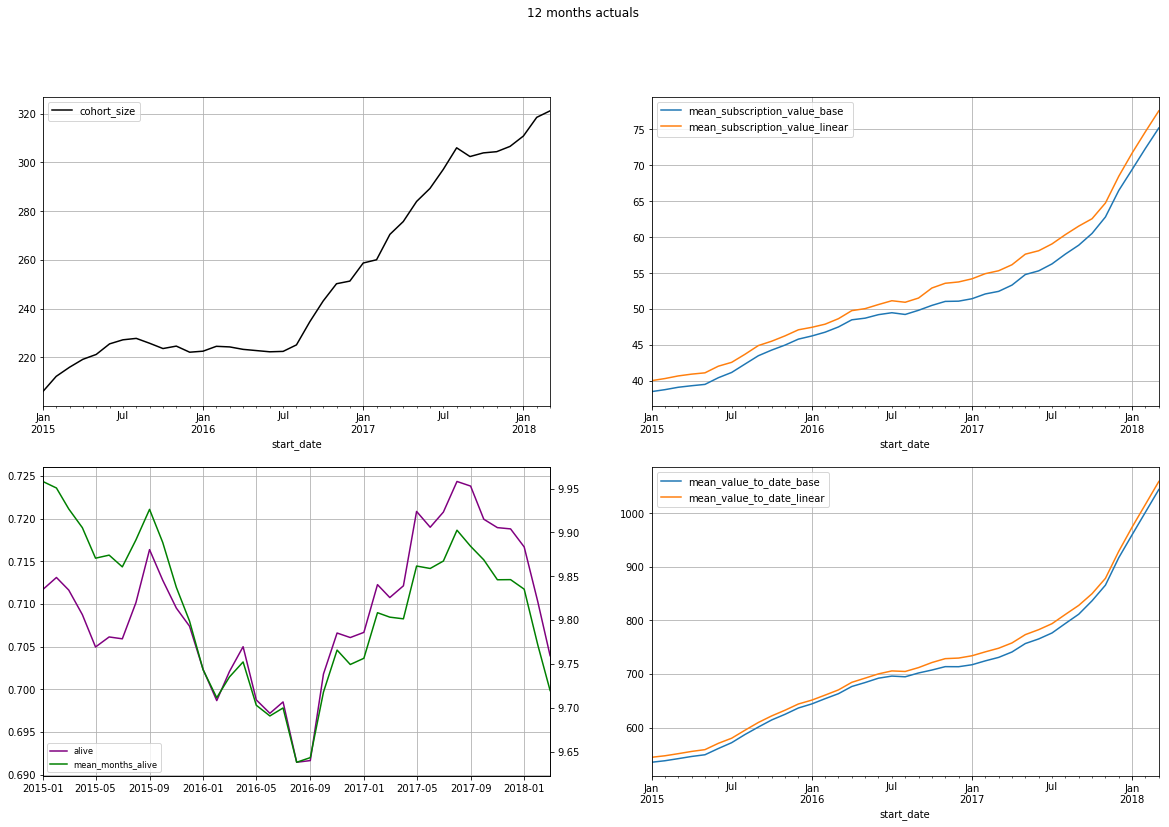

In [128]:
actuals = rep.observed_ltv_by_cohort(smoothing=12)
actuals = actuals.loc["2015-01-01":]

fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(20, 12.5), sharex=False)
fig.suptitle("12 months actuals")

actuals[["cohort_size"]].plot(ax=ax[0][0], c='black')
actuals[["mean_subscription_value_base"]].plot(ax=ax[0][1])
actuals[["mean_subscription_value_linear"]].plot(ax=ax[0][1])
actuals[["mean_value_to_date_base"]].plot(ax=ax[1][1])
actuals[["mean_value_to_date_linear"]].plot(ax=ax[1][1])


ax01_2 = ax[1][0].twinx()
# a = actuals[["alive"]].plot(ax=ax01_2, c='purple')
# b = actuals[["mean_months_alive"]].plot(ax=ax[1][0], c='green')
a, = ax[1][0].plot(actuals.index, actuals["alive"], color='purple', label='alive')
b, = ax01_2.plot(actuals.index, actuals["mean_months_alive"], color='green', label='mean_months_alive')
p = [a, b]
ax[1][0].legend(p, [p_.get_label() for p_ in p], loc='lower left', fontsize='small')
ax01_2.set_xbound((actuals.index[0], actuals.index[-1]))

for rax in ax:
    for cax in rax:
        cax.grid(True)


# Traditional

,avg_subscription_value,avg_arpu_6m,churn_rate,avg_churn_6m
end_of_month,,,,
2018-09-30,90.595969,87.926751,0.023214,0.022722
2018-10-31,91.757487,89.079597,0.023556,0.022374
2018-11-30,92.209652,90.097155,0.025858,0.023085
2018-12-31,92.688864,90.971103,0.021940,0.023423
2019-01-31,93.198915,91.729679,0.025922,0.024108
2019-02-28,93.518542,92.328238,0.023589,0.024013


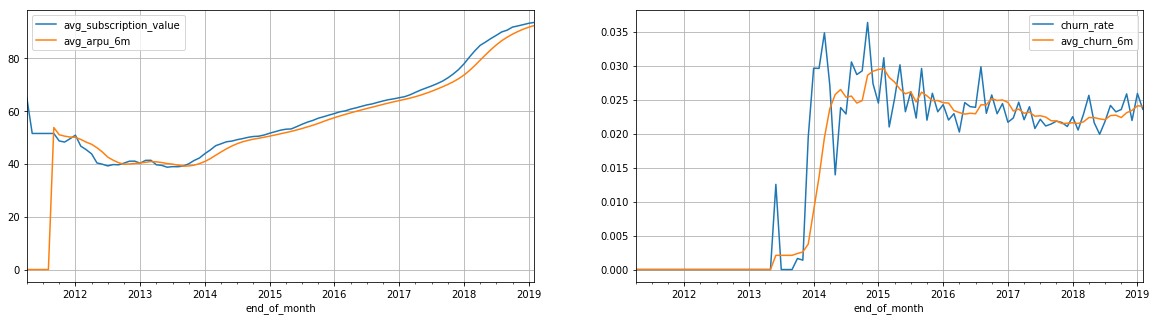

In [36]:
def _churn_rate(df):
    df["churn_rate"] = (df["is_cancelation_month"] / df["alive"]).fillna(0)
    df["avg_churn_6m"] = df['churn_rate'].rolling(window=6).mean().fillna(0)
    return df


def _arpu_progression(df):
    df["subscription_value_base"] = df["subscription_value_base"] / df["alive"]
    df["avg_arpu_6m"] = df["subscription_value_base"].rolling(window=6).mean().fillna(0)
    df = df.rename(columns={"subscription_value_base": "avg_subscription_value"})
    return df

cdf = (
    data.cdf
    .groupby("end_of_month")
    .agg({
        'alive': "sum",
        "is_starting_month": 'sum',
        'is_cancelation_month': 'sum',
        "subscription_value_base": "sum",
    })
    .pipe(_arpu_progression)
    .pipe(_churn_rate)
    [["avg_subscription_value", "avg_arpu_6m", "churn_rate", "avg_churn_6m"]]
)

fig, ax = plt.subplots(1, 2, figsize=(20, 5))
cdf.plot(y=["churn_rate", "avg_churn_6m"], ax=ax[1])
cdf.plot(y=["avg_subscription_value", "avg_arpu_6m"], ax=ax[0])
for axis in ax:
    axis.grid(True)
cdf.tail(6)

In [40]:
sum([data.df[data.df["alive"] > 0]["subscription_current"].mean() * (1 - cdf.iloc[-1].loc["avg_churn_6m"]) ** m for m in range(12)])

1066.2123238630224

# SBG

In [47]:
sbg = SBGSurvival(
    age='age',
    alive='alive',
    features=["country", "industry", "frequency"],
    gamma=1e-3,
    verbose=False
)

In [48]:
%time sbg.fit(data.dtr[data.dtr["start_date"] < "2019-01-01"])

CPU times: user 1min 27s, sys: 161 ms, total: 1min 27s
Wall time: 1min 27s


In [49]:
retention = sbg.predict_survival(data.dva, age=1, n_periods=13)

probability    10.560717
traditional    11.213843
alive          10.605948
dtype: float64

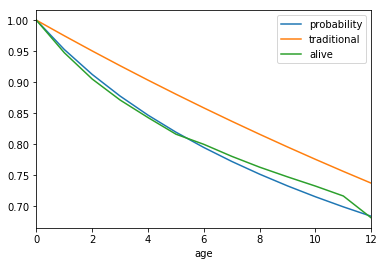

In [50]:
test = retention.groupby(retention.index.get_level_values("age")).mean()
test['traditional'] = [(1 - 0.025065) ** m for m in range(13)]
test = test.join((
    data.cdva
    .query("age <= 12")
    .join(data.cdva.query("age == 12").reset_index(level=1)[[]], how="inner")
    .groupby("age")
    .agg({"alive": "mean"})
))
test.loc[0, "alive"] = 1

test.plot()
test.sum()

             frequency
probability  annual       11.893853
             monthly      10.275850
alive        annual       12.280987
             monthly      10.197752
dtype: float64

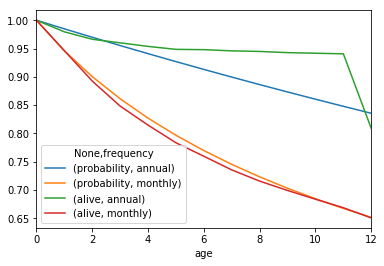

In [51]:
test = (
    retention
    .join(data.dva[["frequency"]])
    .reset_index('age')
    .groupby(["age", "frequency"])
    .agg({"probability": "mean"})
    .unstack()
)
# test['traditional'] = [(1 - 0.025065) ** m for m in range(13)]
test = test.join((
    data.cdtr
    .join(data.dtr[["frequency"]], how="inner")
    .query("age <= 12")
    .join(data.cdtr.query("age == 12").reset_index(level=1)[[]], how="inner")
    .groupby(["age", "frequency"])
    .agg({"alive": "mean"})
    .unstack()
))
test.loc[0] = 1

test.plot()
test.sum()

In [52]:
def _expected_value_to_date(df):
    d = df.copy()
    d["expected_payment"] = d["probability"] * d["subscription_initial"]
    d["expected_value_to_date"] = (
        d
        .groupby(d.index.get_level_values("account_id"))
        .agg({"expected_payment": "cumsum"})
    )
    return d

(
    retention
    .join(data.dva["subscription_initial"])
    .pipe(_expected_value_to_date)
    .reset_index("age")
    .query("age == 11")
    .describe(percentiles=[0.1, 0.5, 0.9])
    .loc[["mean", "10%", "50%", "90%"]]
)

,age,probability,subscription_initial,expected_payment,expected_value_to_date
mean,11.0,0.699221,86.802731,60.191509,853.146768
10%,11.0,0.594097,39.000000,27.548964,388.947862
50%,11.0,0.676802,77.000000,51.803252,739.207862
90%,11.0,0.850431,145.000000,103.455450,1421.593023
